In [331]:
from alphaengine import loaders, stats
import numpy as np
import talib as ta
from itertools import product
from statsmodels.stats.weightstats import ttest_ind
import matplotlib.pyplot as plt
import csv
from datetime import datetime

In [326]:
# FAST MONTE CARLO
# Take asset returns, shuffle it X times (number of simulations). Now you have your returns.
# Shuffle the strategies as well so you can access them still with an index
# 1. generate samplese * simulations size 1d array of random numbers
# 2. 

In [327]:
class Node:
    def __init__(self, value):
        self.value = value
        
    def evalutate(self, asset):
        raise NotImplementedError
        
class Feature(Node):
    def evaluate(self, asset):
        return asset[self.value]

class Constant(Node):
    def evaluate(self, asset):
        return self.value

class Factor:
    def __init__(self, left: Feature, right: Node, comparator):
        self.left = left
        self.right = right
        self.comparator = comparator
        
    def evaluate(self, asset):
        return self.comparator(self.left.evaluate(asset), self.right.evaluate(asset))
    
class BuyAndHold(Factor):
    @staticmethod
    def evaluate(asset):
        return np.ones(len(asset['close'])).astype(bool)

In [328]:
# The basic CSV instrument. We'll abstract this later when we need it
class FileInstrument:
    def __init__(self, filename, load=True):
        self.datetime_format = '%Y-%m-%d %H:%M:%S'
        self.column_names = ['day', 'month', 'year', 'hour', 'minute', 'second', 'open', 'high', 'low', 'close', 'volume', 'forward_returns']
        self.column_set = set(self.column_names)
        
        self.data = None
        
        if load:
            self.load_file(filename)
        
    def load_file(self, filename):
        with open(filename) as f:
            item = []
            reader = csv.reader(f)
            for row in reader:
                _row = self.format_row(*row)
                item.append(_row)
                
        item = np.array(item)
        returns = np.expand_dims(np.diff(item[:,-2], append=item[:,-2][-1]), axis=1)
        
        items_with_returns = np.hstack((item, returns))
        self.data = items_with_returns
        
    def format_row(self, *args):
        date = datetime.strptime(args[0], self.datetime_format)
        o = float(args[1])
        h = float(args[2])
        l = float(args[3])
        c = float(args[4])
        v = int(args[5])

        return [date.day, date.month, date.year, date.hour, date.minute, date.second, o, h, l, c, v]
    
    def attach_feature(self, feature, name):
        self.column_set.add(name) # this will fail if the feature already exists
        self.column_names.append(name)
        
        f = np.expand_dims(feature, axis=1)
        self.data = np.hstack((self.data, f))
    
    def __getitem__(self, key):
        if type(key) == str:
            idx = self.column_names.index(key)
            return self.data[:,idx]
        
        return self.data.__getitem__(key)

    def __repr__(self):
        return self.data.__repr__()

In [329]:
def monte_carlo(asset, strategy, samples=1000, simulations=1000):
    returns = asset['forward_returns'][strategy]

    if len(returns) == 0:
        return np.zeros((samples, simulations))

    strawbroom = np.stack([np.cumsum(np.random.choice(returns, samples)) for _ in range(simulations)])
    return strawbroom

In [479]:
aapl = loaders.FileInstrument('../../../Developer/Data/prices/FOREX/EURUSD.csv')
d = np.diff(aapl['close'], prepend=aapl['close'][0])
aapl.attach_feature(d, 'back_returns')

In [400]:
for i in range(10):
    aapl.attach_feature(ta.RSI(aapl['close'], timeperiod=(i+1)*10), f'rsi_{(i+1)*10}')

In [401]:
factor = Factor(Feature('rsi_60'), Constant(60), np.greater)

In [402]:
factor.evaluate(aapl)

array([False, False, False, ..., False, False, False])

In [480]:
constants = [Constant(i+1) for i in range(100)]
comparators = [np.greater, np.less]
features = [Feature('back_returns') for i in range(1)]

In [481]:
factors = [Factor(*f) for f in product(constants, features, comparators)]

In [482]:
len(factors)

200

In [406]:
def calculate_p_score(asset, strategy, bh, samples=1000, simulations=1000):
    mc = monte_carlo(asset, strategy, samples=samples, simulations=simulations)
    _, p, _ = ttest_ind(mc[:,-1], bh[:,-1], alternative='larger')
    return p, mc

In [407]:
bh = monte_carlo(aapl, BuyAndHold.evaluate(aapl), samples=1000, simulations=1000)

In [408]:
def generate_random_monte_carlo_indexes(samples=1000, simulations=1000):
    x = np.random.rand(samples * simulations)
    y = np.reshape(x, (samples, simulations)).argsort()
    return y

In [483]:
idx = generate_random_monte_carlo_indexes(5000, 1000)

In [484]:
fn = np.stack([f.evaluate(aapl) for f in factors])

In [485]:
idx.shape

(5000, 1000)

In [486]:
fn.shape

(200, 6498)

In [487]:
zzz = aapl['forward_returns'][idx[0]]

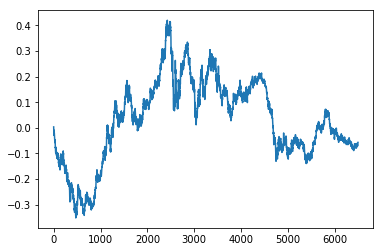

In [488]:
plt.plot(np.cumsum(aapl['forward_returns']))

In [489]:
up = aapl['forward_returns'][aapl['forward_returns'] > 0]
down = aapl['forward_returns'][aapl['forward_returns'] < 0]

(array([310., 270., 173., 223., 177., 116., 171., 130., 104., 120., 125.,
         91.,  94.,  80.,  59.,  90.,  80.,  48.,  60.,  61.,  31.,  46.,
         23.,  28.,  32.,  31.,  14.,  24.,  22.,  19.,  21.,  23.,  13.,
         13.,   8.,   9.,  10.,   6.,   3.,   5.,   7.,   5.,   1.,   7.,
          0.,   5.,   4.,   5.,   3.,   1.,   3.,   2.,   0.,   1.,   0.,
          1.,   0.,   1.,   0.,   1.,   0.,   0.,   2.,   0.,   0.,   1.,
          1.,   1.,   1.,   1.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([1.0000e-04, 5.6600e-04, 1.0320e-03, 1.4980e-03, 1.9640e-03,
        2.4300e-03, 2.8960e-03, 3.3620e-03, 3.8280e-03, 4.2940e-03,
        4.7600e-03, 5.2260e-03, 5.6920e-03, 6.1580e-03, 6.6240e-03,
        7.0900e-03, 7.5560e-03, 8.0220e-03, 8.4880e-03, 8.9540e-03,
        9.4200e-03, 9.8860e-03, 1.0352e-02, 1.

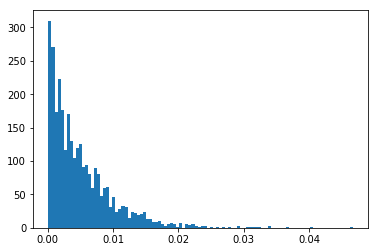

In [490]:
plt.hist(up, bins=100)
# plt.hist(down)

In [491]:
np.sum(up) / np.abs(np.sum(down))

0.9962572102779234

In [492]:
aapl.attach_feature(ta.RSI(aapl['close'], timeperiod=100), 'rsi_100')
aapl.attach_feature(ta.RSI(aapl['close'], timeperiod=50), 'rsi_50')

In [493]:
strat_returns = aapl['forward_returns'][aapl['rsi_50'] > 60]
up = strat_returns[strat_returns > 0]
down = strat_returns[strat_returns < 0]

In [494]:
np.sum(up) / np.abs(np.sum(down))

1.1019193106149636

In [495]:
alpha = (1.461643051036713 / 1.1798021449543412) - 1

In [496]:
bh = stats.monte_carlo(aapl, np.ones(len(aapl['close'])).astype(bool))
rsi100 = stats.monte_carlo(aapl, aapl['rsi_100'] > 60)
rsi50 = stats.monte_carlo(aapl, aapl['rsi_50'] > 60)

(array([ 11.,  16.,  64., 118., 204., 228., 194., 101.,  49.,  15.]),
 array([-0.4312, -0.3049, -0.1786, -0.0523,  0.074 ,  0.2003,  0.3266,
         0.4529,  0.5792,  0.7055,  0.8318]),
 <a list of 10 Patch objects>)

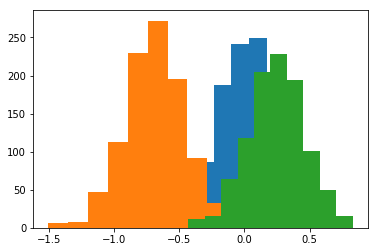

In [497]:
plt.hist(bh[:,-1])
plt.hist(rsi100[:,-1])
plt.hist(rsi50[:,-1])

In [498]:
def alpha(asset, strategy):
    up = asset['forward_returns'][asset['forward_returns'] > 0]
    down = asset['forward_returns'][asset['forward_returns'] < 0]
    bh_alpha = np.sum(up) / np.abs(np.sum(down))
    
    strat_returns = asset['forward_returns'][strategy]
    
    up = strat_returns[strat_returns > 0]
    down = strat_returns[strat_returns < 0]
    strat_alpha = np.sum(up) / np.abs(np.sum(down))
    
    alpha = (strat_alpha / bh_alpha) - 1
    
    return alpha

In [499]:
bh_alpha = alpha(aapl, [True for i in range(len(aapl['forward_returns']))])
rsi_100_alpha = alpha(aapl, aapl['rsi_100'] > 60)
rsi_20_alpha = alpha(aapl, aapl['rsi_20'] > 60)
rsi_50_alpha = alpha(aapl, aapl['rsi_50'] > 60)

ValueError: 'rsi_20' is not in list

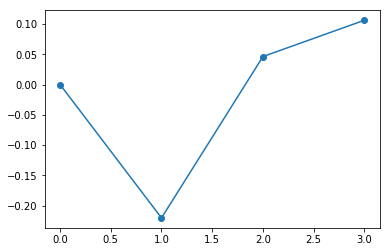

In [500]:
plt.plot([bh_alpha, rsi_100_alpha, rsi_20_alpha, rsi_50_alpha], marker='o')

In [501]:
alphas = [alpha(aapl, f) for f in fn]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [504]:
alphas = []
i = 0
for f in fn:
    a = alpha(aapl, f)
    count = np.sum(f.astype(int))
    if a > 0 and count > 500:
        alphas.append((a, i))
    i += 1

6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0
6498
0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [503]:
max(alphas)

ValueError: max() arg is an empty sequence

In [430]:
x = fn[np.count_nonzero(fn, axis=1) > 500]

In [431]:
x[0]

array([False, False, False, ...,  True,  True,  True])

In [432]:
factors[1155].left.value

58

In [433]:
factors[1155].right.value

'rsi_80'

In [434]:
rsi10 = stats.monte_carlo(aapl, aapl['rsi_80'] > 58)

(array([ 19.,  55.,  99., 186., 235., 192., 128.,  55.,  23.,   8.]),
 array([-0.2852, -0.1657, -0.0462,  0.0733,  0.1928,  0.3123,  0.4318,
         0.5513,  0.6708,  0.7903,  0.9098]),
 <a list of 10 Patch objects>)

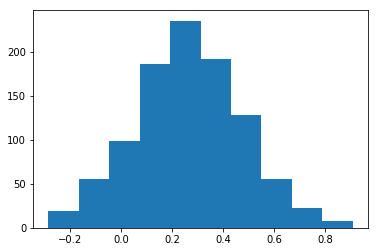

In [435]:
plt.hist(rsi10[:,-1])

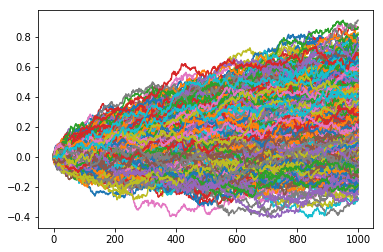

In [436]:
plt.plot(rsi10.T)